In [15]:
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Load the data from the Excel file
data = pd.read_excel('DATA_HOUSEHOLDS_BOX.xlsx')

# Filter the data by region
north_england = data[data['Region_UK'] == 'North England']
south_england = data[data['Region_UK'] == 'South England']
scotland = data[data['Region_UK'] == 'Scotland']

# Define regions and houses within each region
regions = ['North England', 'South England', 'Scotland']
houses = {
    'North England': north_england['Property_ID'].tolist(),
    'South England': south_england['Property_ID'].tolist(),
    'Scotland': scotland['Property_ID'].tolist()
}

house_count = {region: len(houses[region]) for region in regions}

# Thermal parameters (R and C) for each house, extracted from the dataset
R = data.set_index('Property_ID')['R'].to_dict()  # Thermal resistance
C = data.set_index('Property_ID')['C'].to_dict()  # Thermal capacity

# Power consumption and heat pump parameters
COP = 2.44  # Coefficient of performance for all heat pumps, assumed constant
HP_Size_kW = data.set_index('Property_ID')['ColdestR_Value_kW_2'].to_dict()  # Max power of heat pumps

# Maximum hourly consumption for each house (kWh)
MAX_CONS_1H_5 = data.set_index('Property_ID')['MAX_CONS_1H_5'].to_dict()

# Define average hourly power consumption for each region (recorded in kW)
daily_power_consumption = {
    'North England': 94.8053,  
    'South England': 82.3243,  
    'Scotland': 303.901     
}

# Minimum external temperature for each house
Tout_min = data.set_index('Property_ID')['TEMP_EXT_COLDEST_R_5'].to_dict()

# Initial internal temperature for each house from the dataset
initial_temperatures = data.set_index('Property_ID')['MIN_TEMP_COLDEST_R_5'].to_dict()

# Create the Pyomo model
model = ConcreteModel()

# Define a set for all houses across the regions
model.houses = Set(initialize=[house for region in regions for house in houses[region]])

# Define a time set with 0.5-hour intervals over a 24-hour period
model.t = RangeSet(1, 48)  # 24 hours, 0.5-hour intervals

# Decision variables for the duration of the power outage in each region (in hours)
model.outage_duration = Var(regions, within=NonNegativeReals)

# Variables representing the internal temperature for each house at each time interval
model.Tin = Var(model.houses, model.t, within=Reals)

# Binary variables to indicate if the internal temperature drops below 18°C at any interval
model.below_18 = Var(model.houses, model.t, within=Binary)
model.affected = Var(model.houses, within=Binary)

# Binary variables to indicate if the power outage is active at a specific time in each region
model.outage_active = Var(regions, model.t, within=Binary)

# Power consumed by each house at each time interval
model.power = Var(model.houses, model.t, within=NonNegativeReals)

# Ensure that outage duration equals the sum of the time intervals when the outage is active
def outage_active_rule(model, region):
    return model.outage_duration[region] == sum(model.outage_active[region, t] for t in model.t) / 2

model.outage_active_constraint = Constraint(regions, rule=outage_active_rule)

# Ensure that the outages are consecutive
def consecutive_outage_rule(model, region, t):
    if t > 1:
        return model.outage_active[region, t] <= model.outage_active[region, t-1]
    else:
        return Constraint.Skip

model.consecutive_outage_constraint = Constraint(regions, model.t, rule=consecutive_outage_rule)

# Ensure that the outage duration for each region is at least 0.5 hours
def minimum_outage_duration_rule(model, region):
    return model.outage_duration[region] >= 0.5

model.minimum_outage_duration_constraint = Constraint(regions, rule=minimum_outage_duration_rule)

# Thermal dynamics constraint: defines how the internal temperature changes over time
def thermal_dynamics_rule(model, house, t):
    region = data.set_index('Property_ID')['Region_UK'][house]
    if t < 48:  
        delta_t = 0.5  # Time step in hours
        heating_power = COP * model.power[house, t] / C[house]  # Power-based heating with COP
        
        # Thermal dynamics equation discretised using the Euler method
        return model.Tin[house, t+1] == model.Tin[house, t] + delta_t * (
            (Tout_min[house] - model.Tin[house, t]) / (R[house] * C[house]) 
            + (1 - model.outage_active[region, t]) * heating_power)
    else:
        return Constraint.Skip  # Skip the last iteration

model.thermal_dynamics = Constraint(model.houses, model.t, rule=thermal_dynamics_rule)

# Initial temperature condition using the data from 'MIN_TEMP_COLDEST_R_5'
model.initial_temperature = Param(model.houses, initialize=initial_temperatures)

def initial_temperature_rule(model, house):
    return model.Tin[house, 1] == model.initial_temperature[house]  # Set the initial internal temperature per house

model.initial_temperature_constraint = Constraint(model.houses, rule=initial_temperature_rule)

# Power constraints: Ensure power does not exceed HP size and matches energy limits
def power_constraint_rule(model, house, t):
    # Ensure that power consumed by each house does not exceed the heat pump size divided by COP
    return model.power[house, t] <= HP_Size_kW[house] / COP

model.power_constraint = Constraint(model.houses, model.t, rule=power_constraint_rule)

# Variable to capture the temperature deficit when the outage is active

model.temperature_deficit = Var(model.houses, model.t, within=Reals)

def temperature_deficit_rule(model, house, t):
    region = data.set_index('Property_ID')['Region_UK'][house]
    return model.temperature_deficit[house, t] == model.outage_active[region, t] * (18 - model.Tin[house, t])

model.temperature_deficit_constraint = Constraint(model.houses, model.t, rule=temperature_deficit_rule)

# Constraint to ensure that if the temperature drops below 18°C during an outage, the house is marked as affected in t+1
def temp_min_rule(model, house, t):
    region = data.set_index('Property_ID')['Region_UK'][house]
    if t < 48:  # Ensure that t+1 does not exceed the time range
        return model.below_18[house, t+1] >= model.outage_active[region, t] * (1 - model.Tin[house, t+1] / 18)
    else:
        return Constraint.Skip

model.temp_min_constraint = Constraint(model.houses, model.t, rule=temp_min_rule)

# Constraint to mark a house as affected if temperature drops below 18°C at any point in t+1
def affected_rule(model, house):
    return 50 * model.affected[house] >= sum(model.below_18[house, t] for t in model.t)

model.affected_constraint = Constraint(model.houses, rule=affected_rule)

# Energy saving constraint: ensures total energy saved across all regions is at least 1443.0921 kWh
def energy_saving_rule(model):
    total_saving = sum(daily_power_consumption[region] * model.outage_duration[region] for region in regions)
    return total_saving >= 1443.0921  # Ensure the total energy saved is at least 1443.0921 kWh

model.energy_saving = Constraint(rule=energy_saving_rule)

# Penalty slack variable for the number of affected houses
model.penalty_slack = Var(within=NonNegativeReals)

# Constraint to define the penalty slack based on the number of affected houses
def penalty_slack_rule(model):
    return model.penalty_slack >= sum(model.affected[house] for house in model.houses)

model.penalty_slack_constraint = Constraint(rule=penalty_slack_rule)

# Objective function: minimize the squared temperature deficit across all households and time intervals
# Adding a penalty for the number of affected houses
penalty_factor = 10  # This factor is to control the severity of the penalty

model.obj = Objective(
    expr=sum(model.temperature_deficit[house, t] * model.temperature_deficit[house, t] for house in model.houses for t in model.t)
    + penalty_factor * model.penalty_slack,
    sense=minimize
)

# Solve the model using Gurobi
opt = SolverFactory('gurobi')
results = opt.solve(model, tee=True)

# Display the optimal outage duration for each region
for region in regions:
    print(f"Optimal outage duration in {region}: {model.outage_duration[region].value} hours")

# Display which houses are affected
for house in model.houses:
    if model.affected[house].value > 0.5:
        region = data.loc[data['Property_ID'] == house, 'Region_UK'].values[0]
        print(f"House {house} in {region} is affected.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-12
Read LP format model from file C:\Users\maria\AppData\Local\Temp\tmpp0vd4nr4.pyomo.lp
Reading time = 0.15 seconds
x1: 10499 rows, 40099 columns, 20929 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22621.2))

CPU model: AMD Ryzen 7 4800HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 10499 rows, 40099 columns and 20929 nonzeros
Model fingerprint: 0xb6eed688
Model has 9936 quadratic objective terms
Model has 29394 quadratic constraints
Variable types: 29812 continuous, 10287 integer (10287 binary)
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [2e-02, 2e+01]
  Objective range  [1e+01, 1e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+03]
  

In [16]:
#Print Total savings
total_saving = sum(daily_power_consumption[region] * model.outage_duration[region].value for region in regions)
print(f"Total energy saved: {total_saving} kWh")

Total energy saved: 1449.3323 kWh


In [17]:
df_results = pd.DataFrame(columns=[t for t in model.t])
df_results['Property_ID'] = model.houses
df_results['Region'] = [data.loc[data['Property_ID'] == house]['Region_UK'].values[0] for house in model.houses]
df_results.set_index('Property_ID', inplace=True)
for house, hour in model.Tin:
    df_results.loc[house, hour] = model.Tin[house, hour].value
df_results.to_excel('house_temps_test7.xlsx')

df_temperatures = pd.DataFrame(columns={"Property_ID": model.houses})
df_temperatures['Property_ID'] = model.houses
df_temperatures['Region'] = [data.loc[data['Property_ID'] == house]['Region_UK'].values[0] for house in model.houses]
df_temperatures["isUnder18"] = [model.affected[house].value for house in model.houses]

# Append these results to the existing Excel file as a new sheet

active_outage = pd.DataFrame(columns=[t for t in model.t])
active_outage['Region'] = regions
active_outage.set_index('Region', inplace=True)
for region, hour in model.outage_active:
    active_outage.loc[region, hour] = model.outage_active[region, hour].value
with pd.ExcelWriter('house_temps_test7.xlsx', mode='a') as writer:
    active_outage.to_excel(writer, sheet_name='active_outage')

In [18]:
# Iterate through each region to find the last time step of the outage
for region in regions:
    last_outage_time = 0
    for t in range(1, 49):  # 48 time steps (1 to 48)
        if model.outage_active[region, t].value == 1:
            last_outage_time = t
    
    # Now, check the internal temperature at the next time step (t + 1)
    houses_below_18 = 0
    if last_outage_time < 48:  # Ensure we don't go out of bounds
        for house in houses[region]:
            if model.Tin[house, last_outage_time + 1].value < 18:
                houses_below_18 += 1
    
    # Calculate the percentage of affected houses
    percentage_affected = (houses_below_18 / house_count[region]) * 100
    
    # Print the number and percentage of affected houses
    print(f"Number of houses affected in {region} after the outage: {houses_below_18}")
    print(f"Percentage of houses affected in {region} after the outage: {percentage_affected:.2f}%")

Number of houses affected in North England after the outage: 28
Percentage of houses affected in North England after the outage: 48.28%
Number of houses affected in South England after the outage: 20
Percentage of houses affected in South England after the outage: 58.82%
Number of houses affected in Scotland after the outage: 73
Percentage of houses affected in Scotland after the outage: 63.48%


In [19]:
# Iterate through each region to find the last time step of the outage
for region in regions:
    last_outage_time = 0
    for t in range(1, 49):  # 48 time steps (1 to 48)
        if model.outage_active[region, t].value == 1:
            last_outage_time = t
    
    # Now, check the internal temperature at the next time step (t + 1)
    houses_below_145 = 0
    if last_outage_time < 48:  # Ensure we don't go out of bounds
        for house in houses[region]:
            if model.Tin[house, last_outage_time + 1].value < 14.5:
                houses_below_145 += 1
    
    # Calculate the percentage of affected houses
    percentage_affected = (houses_below_145 / house_count[region]) * 100
    
    # Print the number and percentage of affected houses
    print(f"Number of houses affected in {region} after the outage: {houses_below_145}")
    print(f"Percentage of houses affected in {region} after the outage: {percentage_affected:.2f}%")

Number of houses affected in North England after the outage: 3
Percentage of houses affected in North England after the outage: 5.17%
Number of houses affected in South England after the outage: 2
Percentage of houses affected in South England after the outage: 5.88%
Number of houses affected in Scotland after the outage: 8
Percentage of houses affected in Scotland after the outage: 6.96%


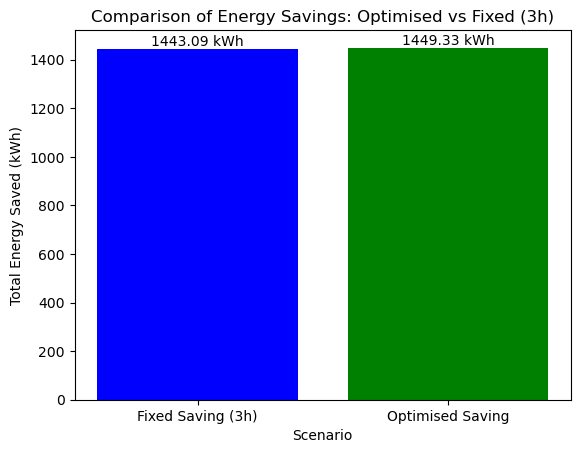

In [27]:
import matplotlib.pyplot as plt

# Calculate total savings with the optimised model
total_saving_optimized = sum(daily_power_consumption[region] * model.outage_duration[region].value for region in regions)

# Savings with a fixed 3-hour outage
total_saving_fixed = 1443.0921  # Fixed value provided

# Data for the histogram (reordered)
savings_data = {
    'Fixed Saving (3h)': total_saving_fixed,
    'Optimised Saving': total_saving_optimized
}

# Create the histogram with specified colors
bars = plt.bar(savings_data.keys(), savings_data.values(), color=['blue', 'green'])

# Add labels on top of each bar to show the exact savings value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f} kWh', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Scenario')
plt.ylabel('Total Energy Saved (kWh)')
plt.title('Comparison of Energy Savings: Optimised vs Fixed (3h)')

# Save the plot to a PDF 
plt.savefig('Energy_Saved.pdf')

# Show the plot
plt.show()


Discomfort Level for Fixed Duration (3 hours): 10426.976001253299
Discomfort Level for Optimised Duration: 5916.316132773577


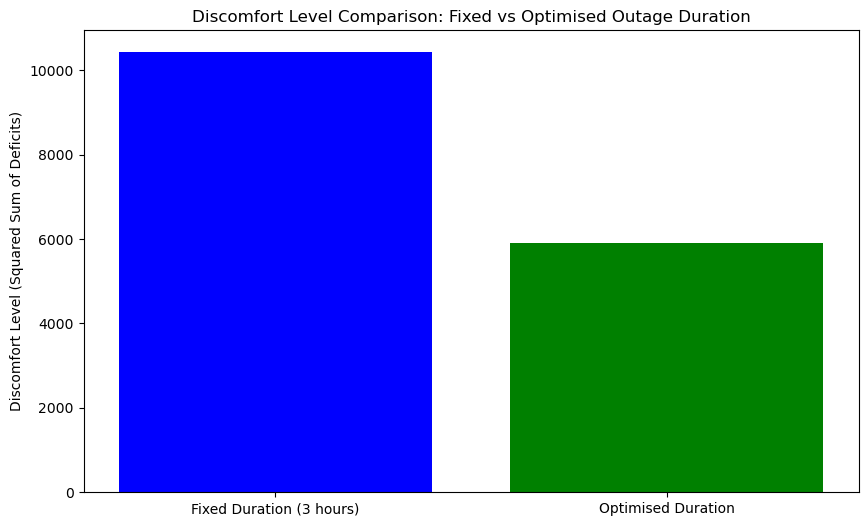

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Create an empty DataFrame to store the evolution of temperatures without heating power
temperature_evolution_no_Q = pd.DataFrame(index=model.houses, columns=range(1, 49))

# Define the function to calculate the temperature evolution without heating power
def calculate_temperature_no_Q(model):
    for house in model.houses:
        for t in range(1, 49):
            if t == 1:
                # Set the initial temperature at t=1
                temperature_evolution_no_Q.at[house, t] = model.Tin[house, t].value
            else:
                # Calculate the temperature evolution without heating power using the Euler method
                delta_t = 0.5  # Time step in hours
                temperature_evolution_no_Q.at[house, t] = temperature_evolution_no_Q.at[house, t-1] + delta_t * (
                    (Tout_min[house] - temperature_evolution_no_Q.at[house, t-1]) / (R[house] * C[house])
                )

# Calculate and store the temperature evolution
calculate_temperature_no_Q(model)

# Save the temperature evolution DataFrame to an Excel file
temperature_evolution_no_Q.to_excel("temperature_evolution_no_heating_2.xlsx")

# Define fixed duration for comparison (3 hours corresponds to t=7)
fixed_duration_t = 7

# Define specific values of t for each region in the optimised scenario
optimised_t_values = {
    'South England': 6,
    'Scotland': 7,
    'North England': 8
}

# Function to calculate the discomfort level using the DataFrame of temperatures without heating power
def calculate_discomfort_no_Q(df_temperatures, houses, t):
    total_deficit = 0
    for house in houses:
        deficit = 18 - df_temperatures.at[house, t]
        total_deficit += deficit
    discomfort = total_deficit ** 2  # Apply the squared sum of all deficits
    return discomfort

# Calculate discomfort level for the fixed duration scenario using the new DataFrame
discomfort_fixed_duration_no_Q = calculate_discomfort_no_Q(temperature_evolution_no_Q, model.houses, fixed_duration_t)
print(f"Discomfort Level for Fixed Duration (3 hours): {discomfort_fixed_duration_no_Q}")

# Calculate discomfort level for the optimised duration scenario using the new DataFrame
discomfort_optimised_no_Q = 0
for region, t in optimised_t_values.items():
    region_houses = houses[region]
    discomfort_optimised_no_Q += calculate_discomfort_no_Q(temperature_evolution_no_Q, region_houses, t)

print(f"Discomfort Level for Optimised Duration: {discomfort_optimised_no_Q}")

# Plot the results comparing discomfort with and without heating power
labels = ['Fixed Duration (3 hours)', 'Optimised Duration']
values_no_Q = [discomfort_fixed_duration_no_Q, discomfort_optimised_no_Q]

plt.figure(figsize=(10, 6))
plt.bar(labels, values_no_Q, color=['blue', 'green'])
plt.ylabel('Discomfort Level (Squared Sum of Deficits)')
plt.title('Discomfort Level Comparison: Fixed vs Optimised Outage Duration')

# Save the plot to a PDF 
plt.savefig('Discomfort_level.pdf')

plt.show()
